In [1]:
# %matplotlib tk
# %matplotlib qt
import matplotlib.pyplot as plt
plt.xkcd()

Q-Learning Agent (Jax/Flax)
===========================

In [2]:
from typing import Any
from flax import nnx

class LanderNetwork(nnx.Module):
    def __init__(self, layers=None, rngs: nnx.Rngs=None) -> None:
        if rngs is None: rngs = nnx.Rngs(0)
        if layers is None: layers = [8, 128, 128, 4]
        layers = [[nnx.Linear(i, o, rngs=rngs), nnx.relu] for i, o in zip(layers[:-1], layers[1:])]
        layers = sum(layers, [])[:-1]
        self.sequential = nnx.Sequential(
            *layers
            # nnx.Linear(8, 128, rngs=rngs),
            # nnx.relu,
            # nnx.Linear(128, 128, rngs=rngs),
            # nnx.relu,
            # nnx.Linear(128, 4, rngs=rngs)
        )
    def __call__(self, x):
        return self.sequential(x)
        

In [3]:
import numpy as np
ln = LanderNetwork()
ln(np.random.randn(8)).argmax(-1).item()

1

In [4]:
nnx.display(LanderNetwork([8, 512, 256, 4]))

In [4]:
from utils import Agent
from collections import deque
import optax
import jax.numpy as jnp

class TrainableAgent(Agent):
    
    def __init__(
        self, 
        network: nnx.Module, 
        buffer_size=32, batch_size=32,
        gamma=0.9, 
        lr=0.001, 
        train_interval=4, 
        epsilon=0.1
        ) -> None:
        
        self.network = network
        self._training = False
        self.buffer = deque([], maxlen=buffer_size)
        self.batch_size = batch_size
        self.train_interval = train_interval
        self.training_steps = 0
        self.gamma = gamma
        self.losses = []
        self.epsilon=epsilon
        
        self.optim = nnx.Optimizer(self.network, optax.adamw(lr,))
        # self.gradient_on_samples = nnx.jit(nnx.grad(TrainableAgent.evaluate_samples))
        self.gradient_on_samples = nnx.jit(nnx.grad(TrainableAgent.batch_evaluate_samples))
        
        
    def __call__(self, x) -> np.ndarray:
        return self.network(x)
    def train(self):
        self.network.train()
        self._training=True
        return self
    def eval(self):
        self.network.eval()
        self._training=False
        return self
    def act(self, observation, periphral=None):
        if self._training and np.random.rand() < self.epsilon:
            return self._explore(observation)
        return self._exploit(observation)
    def _explore(self, observation):
        return np.random.randint(4)
    def _exploit(self, observation):
        return self.network(observation).argmax(-1).item()
    
    def record_observation(self, observation, action, reward, next_observation, terminated):
        if not self._training:
            return
        self.buffer.append((observation, action, reward, next_observation, int(terminated)))
        self.training_steps+=1
        self.losses.append(self.evaluate_sample(self.network, self.gamma, *self.buffer[-1]))
        
        if self.training_steps%self.train_interval==0 and len(self.buffer) > self.batch_size:
            batch = [self.buffer[i] for i in np.random.choice(np.arange(len(self.buffer)), self.batch_size)]
            self.train_on_samples(self.network, batch)

    def train_on_samples(self, network, samples):
        grads = self.gradient_on_samples(network, self.gamma, samples)
        self.optim.update(grads)
    
    @staticmethod
    def evaluate_samples(network, gamma, samples):
        return np.mean((TrainableAgent.evaluate_sample(network, gamma, *sample) for sample in samples))
    
    @staticmethod
    def batch_evaluate_samples(network: nnx.Module, gamma:int, samples):
        observations, actions, rewards, next_observations, terminateds = zip(*samples)
        terminateds = jnp.array(terminateds)
        rewards = jnp.array(rewards)
        cr_preds = jnp.stack([pred[a] for pred, a in zip(network(observations), actions)])
        cr_estimates = rewards + (1-terminateds)*gamma*network(next_observations).argmax(-1)
        return np.mean((cr_preds-cr_estimates)**2)

    @staticmethod
    def evaluate_sample(network, gamma, observation, action, reward, next_observation, terminated):
        cr_pred = network(observation)[action]
        cr_estimate = reward + (1-terminated)*gamma*network(next_observation).argmax(-1)
        return (cr_pred-cr_estimate)**2

        

Single demo run
---------------

In [16]:
from utils import plot_one_run
import gymnasium as gym
enviz = gym.make("LunarLander-v3", render_mode='human')
tna = TrainableAgent(LanderNetwork()).eval()
plot_one_run(enviz, tna, )
enviz.close()


In [17]:
plt.close()
enviz.close()

Training
--------

In [5]:
# Setup
import gymnasium as gym
env = gym.make("LunarLander-v2")
tna = TrainableAgent(LanderNetwork([8, 256, 256, 4]), buffer_size=50_000, gamma=0.99, lr=0.0005, batch_size=32, train_interval=1)
cont = None
runs = [[]]

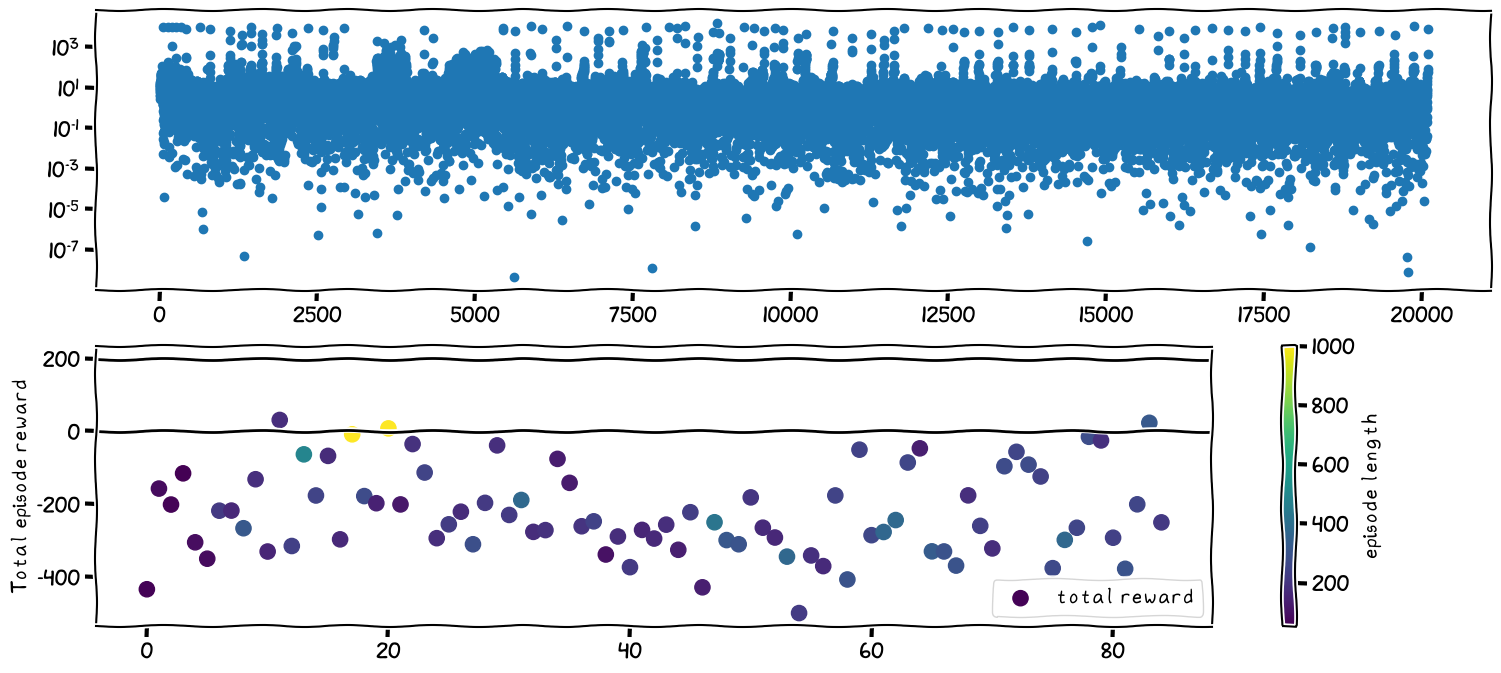

100%|██████████| 20000/20000 [05:59<00:00, 55.69it/s]


In [6]:
from IPython.display import clear_output
from utils import run_upto_n_steps, plot_reward_and_episodes, plot_one_run
from tqdm import trange
import matplotlib.pyplot as plt
def plot_losses_and_runs(losses, runs):
    clear_output(True)
    plt.clf()
    plt.subplot(2, 1, 1)
    plt.scatter(*zip(*enumerate(losses)), )
    plt.yscale('log')
    plt.subplot(2, 1, 2)
    plot_reward_and_episodes(runs[:-1]) if len(runs) > 1 else None
    plt.pause(0.5)

def demo_one_run(agent: Agent):
    plt.clf()
    agent.eval()
    enviz = gym.make("LunarLander-v2", render_mode='human')
    plot_one_run(enviz, agent, clear_func=lambda:clear_output(True))
    enviz.close()
    agent.train()
tna.train()

step_limp = tna.training_steps + 20_000
prog_bar = trange(tna.training_steps, step_limp)
plots=0
demos=0

try:
    while tna.training_steps < step_limp:
        init_steps = tna.training_steps
        cont, runs = run_upto_n_steps(env, tna, 1_000, cont, runs)
        prog_bar.update(np.min([tna.training_steps, step_limp]) - init_steps, )

        if tna.training_steps // 5_000 > demos:
            demo_one_run(tna)
            demos = tna.training_steps//5_000

        if tna.training_steps // 500 > plots:
            plt.figure(figsize=(18, 8))
            plot_losses_and_runs(tna.losses, runs)
            plots = tna.training_steps//500
except KeyboardInterrupt:
    pass
prog_bar.close()

In [14]:
prog_bar.close()

In [ ]:
tna.training_steps, len(tna.losses)

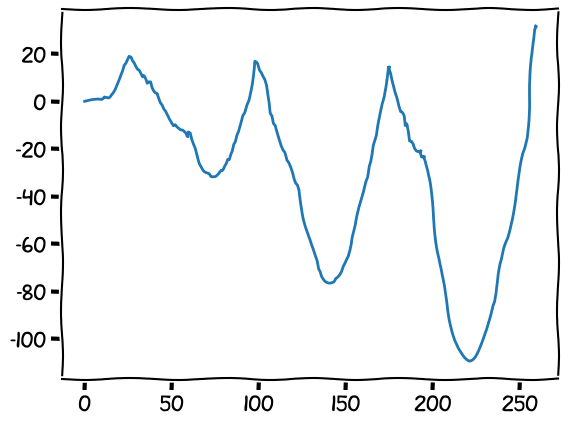

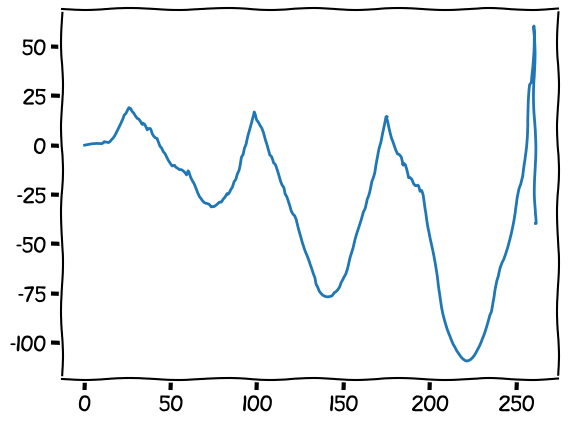

In [7]:
demo_one_run(tna)

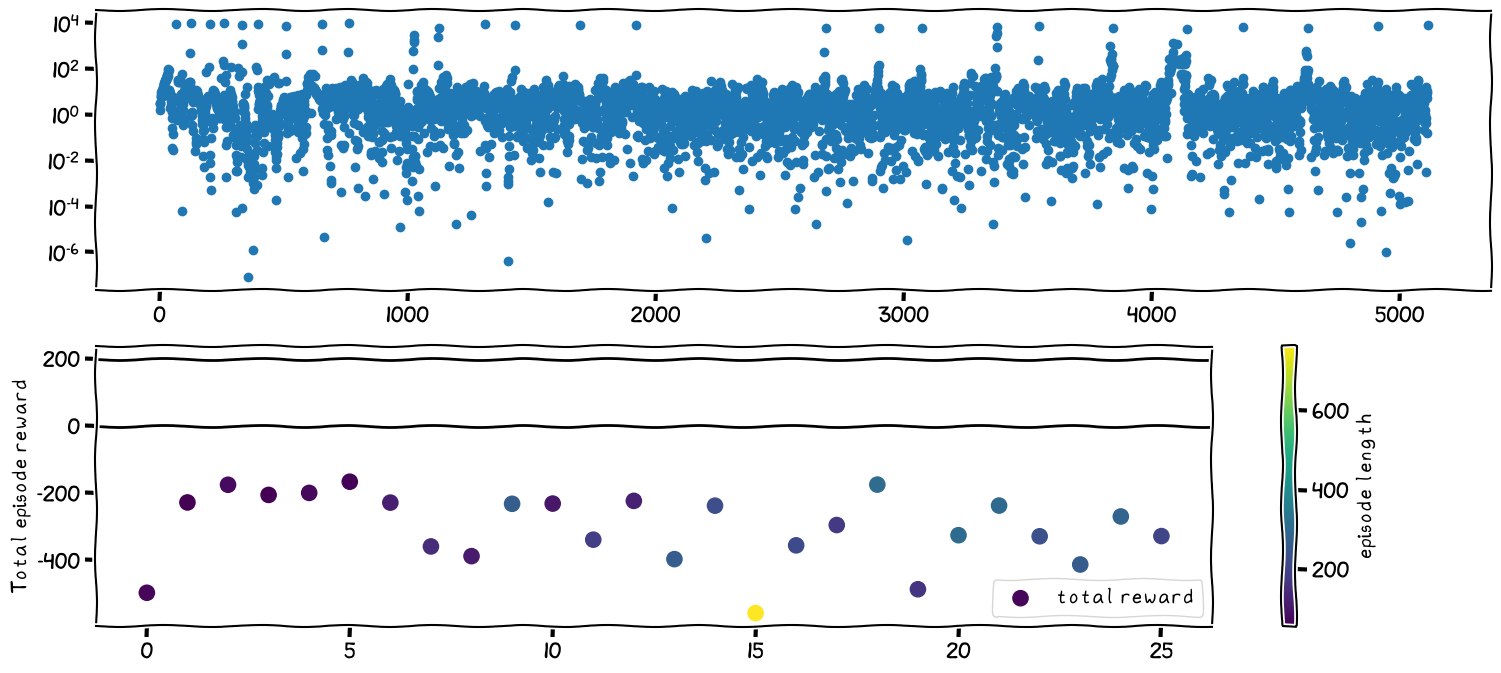

In [15]:
plt.figure(figsize=(18, 8))
plot_losses_and_runs(tna.losses, runs)
# plt.tight_layout()

Q-Learning Agent (pytorch)
==========================

setup
-----

In [46]:
import gymnasium as gym
enviz = gym.make("LunarLander-v3", render_mode='human')
cont = None

In [ ]:
enviz.observation_space.sample().shape

In [ ]:
enviz.action_space

In [49]:
import torch
import torch.nn as nn

class LanderNetwork(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            nn.Linear(8, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 4),
        )
    def forward(self, x):
        return self.layers(x)

Simple Network Agent
--------------------
This is just a simple agent that uses the network but does not train it.


In [10]:
from utils import Agent
class SimpleNetworkAgent(Agent):
    def __init__(self) -> None:
        super().__init__()
        self.network = LanderNetwork()
    def act(self, observation, periphral=None):
        obs = torch.from_numpy(observation)
        action = self.network(obs)
        return action.argmax().item()
    def record_observation(self, observation_old, action, reward, observation, terminated):
        return super().record_observation(observation_old, action, reward, observation, terminated)

sna = SimpleNetworkAgent()
cont = None
runs = [[]]

In [13]:
from utils import plot_one_run

plot_one_run(enviz, sna,)

In [14]:
enviz.close()
# plt.close()

In [15]:
import gymnasium as gym
enviz = gym.make("LunarLander-v3")
cont = None

In [ ]:
from utils import run_upto_n_steps, plot_reward_and_episodes
from tqdm import trange

for round in trange(80):
    cont, runs = run_upto_n_steps(enviz, sna, 150, cont, runs)
    if round % 2 == 0:
        plt.clf()
        plot_reward_and_episodes(runs)
        plt.pause(0.2)

In [18]:
plt.close()

Trainable Network Agent
-----------------------
This agent will train the network by optimizing on the most recent few 
(Observaation, Action, Reward, Observation) quartuples


### Basic

In [54]:
import gymnasium as gym
env = gym.make("LunarLander-v3")
cont = None

In [55]:
import numpy as np
from utils import Agent
class TrainableNetworkAgent(Agent):
    def __init__(self, gamma = 0.9, lr=0.001, update_interval=32, epsilon=0.1) -> None:
        super().__init__()
        self.network = LanderNetwork()
        self.gamma = gamma
        self.update_interval = update_interval
        self.epsilon = epsilon
        self.optim = torch.optim.AdamW(self.network.parameters(), lr)
        self.loss = torch.tensor(0., requires_grad=True)
        self.thoughts = 0
        self.losses = []
        self.events = [] # List of dictionary of events
    def act(self, observation, periphral=None):
        if self.network.training and torch.rand((1,)).item() < self.epsilon:
            return torch.randint(self.network.layers[-1].out_features, (1,)).item()
        obs = torch.from_numpy(observation)
        with torch.no_grad():
            action = self.network(obs)
        return action.argmax().item()
    def record_observation(self, observation, action, reward, observation_next, terminated):
        if not self.network.training:
            return 
        self.thoughts += 1
        if isinstance(observation, np.ndarray):
            observation = torch.from_numpy(observation)
        if isinstance(observation_next, np.ndarray):
            observation_next = torch.from_numpy(observation_next)
        outputs = self.network(observation)
        cr_pred = outputs[action]
        cr_esti = reward + (self.gamma*self.network(observation_next).argmax() if not terminated else 0)

        loss = (cr_esti - cr_pred)**2
        self.loss = self.loss + loss
        self.losses.append(loss.item())
        self.events.append({
            "terminal": terminated,
            "reward": reward
        })
        if self.thoughts % self.update_interval == 0:
            self.update()
        
    def update(self):
        self.optim.zero_grad()
        self.loss.backward()
        self.optim.step()
        self.loss = torch.tensor(0., requires_grad=True)

In [56]:
tna = TrainableNetworkAgent(gamma=0.99, lr=0.01)
cont = None
runs = [[]]

In [ ]:
from utils import run_upto_n_steps, plot_reward_and_episodes
from tqdm import trange
from itertools import count
tna.network.train()
training_steps  = 10_000
progbar = trange(training_steps)

initial_steps = tna.thoughts
breakout = False
for round in count():
    try:
        cont, runs = run_upto_n_steps(env, tna, 150, cont, runs)
        progbar.set_description(f"thoughts {tna.thoughts}")
        progbar.update(tna.thoughts-initial_steps-progbar.n)
        if progbar.n-initial_steps >= training_steps:
            breakout = True
        if round % 20 == 0 or breakout:
            # plot_agent(tna)
            plt.clf()
            plt.subplot(2,1,1)
            plt.scatter(*zip(*enumerate(tna.losses)), c=[i['terminal'] for i in tna.events], s=120, alpha=0.8)
            plt.yscale('log')
            plt.subplot(2, 1, 2)
            plot_reward_and_episodes(runs)
            plt.pause(0.2)
        if round % 300 == 0 or breakout:
            tna.network.eval()
            enviz = gym.make("LunarLander-v3", render_mode='human')
            run_upto_n_steps(enviz, tna, 1_000)
            enviz.close()
            tna.network.train()
        if breakout:
            break
    except KeyboardInterrupt:
        break
progbar.close()

In [28]:
from utils import plot_one_run
enviz = gym.make("LunarLander-v3", render_mode='human')
tna.network.eval()
plot_one_run(enviz, tna,)
enviz.close()


In [ ]:
# plt.close()
plt.suptitle("Simple DQN")

### Multiple Parallel environments

This paper [Asynchronous Methods for Deep Reinforcement Learning](https://arxiv.org/abs/1602.01783) 
demonstrated a strategy of training the same agent in multiple different copies 
of the environment at the same time as a method to keep diversity in training 
data.

This section is my attempt to recreate that


steps:
- ~~Seperate runs from agent, make run an array returned along side cont~~
- ~~Verify nothing broke~~
- Implement env&run swap in training loop
- ...?
- Profit?

In [4]:
from utils import TrainableNetworkAgent
import gymnasium as gym
import numpy as np

tna = TrainableNetworkAgent(gamma=0.99, lr=0.01)
envs = [gym.make("LunarLander-v3") for _ in range(5)] 
num_envs = len(envs)
cont = [None]*num_envs
runs = [ [[]] ]*num_envs
# epsilons = np.linspace(0.9, 0.1, num_envs)
epsilons = [0.1]*num_envs

In [ ]:
from utils import run_upto_n_steps, plot_reward_and_episodes
from tqdm import trange
from itertools import count

tna.network.train()
training_steps  = 80_000
progbar = trange(training_steps)

initial_steps = tna.thoughts
breakout = False
for round in count():
    try:
        enviz = round%num_envs
        tna.epsilon = epsilons[enviz]
        cont[enviz], runs[enviz] = run_upto_n_steps(envs[enviz], tna, 40, cont[enviz], runs[enviz])
        progbar.set_description(f"thoughts {tna.thoughts}")
        progbar.update(tna.thoughts-initial_steps-progbar.n)
        if progbar.n-initial_steps >= training_steps:
            breakout = True
        if round % 20 == 0:
            # plot_agent(tna)
            plt.clf()
            plt.subplot(2,1,1)
            plt.scatter(*zip(*enumerate(tna.losses)), c=[i['terminal'] for i in tna.events], s=10, alpha=0.8)
            plt.subplot(2, 1, 2)
            plot_reward_and_episodes(runs[-1])
            plt.pause(0.2)
        if round % 500 == 0:
            tna.network.eval()
            enviz = gym.make("LunarLander-v3", render_mode='human')
            run_upto_n_steps(enviz, tna, 1_000)
            enviz.close()
            tna.network.train()
        if breakout:
            break
    except KeyboardInterrupt:
        break
progbar.close

In [ ]:
enviz = gym.make("LunarLander-v3", render_mode='human')
tna.network.eval()
for i in trange(5):
    run_upto_n_steps(enviz, tna, 1_000)
# input()
enviz.close()


In [22]:
plt.close()

# Random Agent

In [1]:
%matplotlib tk
# %matplotlib qt

In [2]:
from utils import Agent, run_upto_n_steps
import numpy as np
class RandLander(Agent):
    def act(self, observation, periphral=None):
        return np.random.choice([0,1,2,3])
    def record_observation(self, observation_old, action, reward, observation, terminated):
        pass

rand_agent = RandLander()



In [3]:
from utils import Agent, run_upto_n_steps
import gymnasium as gym

enviz = gym.make("LunarLander-v3", render_mode="human")
cont = None

In [4]:
import logging
# logging.basicConfig(level=logging.INFO) # If your interested in some logs

In [5]:
from utils import run_and_plot

for round in range(100):
    cont = run_and_plot(enviz, rand_agent, 50, cont)

In [6]:
enviz.close()

In [7]:
import gymnasium as gym
enviz = gym.make("LunarLander-v3")
cont = None

In [10]:
from utils import run_and_plot

for round in range(100):
    cont = run_and_plot(enviz, rand_agent, 150, cont)

# Utils

In [3]:
import gymnasium as gym

enviz = gym.make("LunarLander-v3", render_mode="human")
next_observation, info = enviz.reset()

episode_over = False
while not episode_over:
    action = enviz.action_space.sample()  # agent policy that uses the observation and info
    next_observation, reward, terminated, truncated, info = enviz.step(action)

    episode_over = terminated or truncated

enviz.close()

define a function that takes a model and an environment, and run the model in the environment for *n* steps

In [22]:
import gymnasium as gym
from abc import ABC, abstractmethod

class Agent(ABC):
    @abstractmethod
    def act(self, observation, periphral=None):
        pass
    @abstractmethod
    def think(self, observation_old, action, reward, observation):
        pass

def run_n_steps(env, agent: Agent, n, continuation=None):
    if continuation is not None:
        observation, reward, terminated, truncated, info = continuation
    if continuation is None or terminated or truncated:
        print("Resetting")
        observation, info = env.reset()
        terminated = False
        truncated = False
        reward = 0
    step = 0
    # print((observation, reward, terminated, truncated, info))
    while not terminated and not truncated and step < n:
        action = agent.act(observation)
        observation_old = observation
        observation, reward, terminated, truncated, info = env.step(action)
        agent.think(observation_old, action, reward, observation)
        step += 1
    return (observation, reward, terminated, truncated, info)

In [ ]:
enviz = gym.make("LunarLander-v3", render_mode='human')

class RandomLunar(Agent):
    def act(self, observation, periphral=None):
        return enviz.action_space.sample()
    def think(self, observation_old, action, reward, observation):
        return super().think(observation_old, action, reward, observation)
randAgent = RandomLunar()


cont = run_n_steps(enviz, randAgent, 10)

In [93]:
cont = run_n_steps(enviz, randAgent, 10, cont)

In [94]:
enviz.close()